Some poker models I've created to have greater clarity on the tradeoff between EV and variance when deciding which stakes and how much volume to play. These are based on the primedope model (primedope.com) but I've added support for stuff like playing several stakes and a bad beat jackpot payout.

In [115]:
import numpy as np
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

In [116]:
#function for computing the weighted average and standard deviation, used in a few models
def weighted_avg_and_sd(values, weights):
    avg = np.average(values, weights=weights)
    var = np.average((values-avg)**2, weights=weights)
    sd = var**.5
    return (avg, sd)


This first model allows multiple stakes to be played, which prime dope does not support. The inputs for stakes are meant to be in dollars and the individual entries represent the dollar amounts of the big blind. Inputs for the winrates and sd are given per 100 hands, as is the standard in poker software.
The results from individual hands are assumed to follow a Normal distribution. This is far from the case in reality but it is convenient to assume and after only a few hundred hands we get reasonable converge to a Normal distribution from the Central Limit theoren. Justification found towards the end of the notebook.
Outputs for this model mostly follow from the properties of the sums of iid distributions.

EV: 8200.00
standard deviation of winnings: 427.36
Sharpe ratio: 19.19
70% confidence interval on winnings: [-4661.80, 21061.80]
95% confidence interval on winnings: [-16122.51, 32522.51]
99% confidence interval on winnings: [-23765.20, 40165.20]


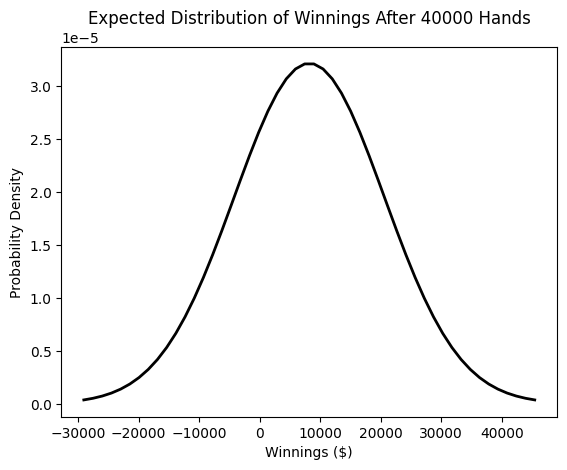

In [117]:
stake_bb = np.array([2,5,10])                  #stake_bb[i] represent the bb value (in $) for the ith stake
n_hands = np.array([10000,20000,10000])        #number of hands to be played at each stake
win_rates_100 = np.array([6,4,3])              #win rate per 100 hands corresponding to each stake. Values from 2 to 8 typical for pros.
sd_100 = np.array([100,100,100])               #sd per 100 hands corresponding to each stake. Values arround 100 typical for 6 handed nlh games.

#computing the values per hand
sd = sd_100*0.1                               #the sd scales with the square root of the number of hands
win_rates = win_rates_100*0.01                #the win rate per hand is .01 of the win rate per 100 hands

stake_mean = n_hands*stakes*win_rates         #computing the EVs per stake
total_mean = sum(stake_mean)                  #total EV in sample
print(f"EV: {total_mean:.2f}")

stake_sigma = n_hands**.5*stake_bb*sd
total_sigma = (np.sum(stake_sigma*stake_sigma))**.5                #standard deviation of the total result across all stakes played
print(f"standard deviation of winnings: {total_sd:.2f}")
print(f"Sharpe ratio: {total_mean/total_sd:.2f}")


mu, sigma = total_mean, total_sigma                          #Expected Normal distribution parameters

#confidence intervals for limiting Normal distribution
conf_70 = [-(norm.ppf(0.85))*sigma + mu, (norm.ppf(0.85))*sigma + mu]
conf_95 = [-(norm.ppf(0.975))*sigma + mu, (norm.ppf(0.975))*sigma + mu]
conf_99 = [-(norm.ppf(0.995))*sigma + mu, (norm.ppf(0.995))*sigma + mu]

print(f"70% confidence interval on winnings: [{conf_70[0]:.2f}, {conf_70[1]:.2f}]")
print(f"95% confidence interval on winnings: [{conf_95[0]:.2f}, {conf_95[1]:.2f}]")
print(f"99% confidence interval on winnings: [{conf_99[0]:.2f}, {conf_99[1]:.2f}]")

#Plotting the distribution
plt.xlabel('Winnings ($)')
plt.ylabel('Probability Density')
plt.title(f'Expected Distribution of Winnings After {sum(n_hands)} Hands')

x = np.linspace(mu - 3*sigma, mu + 3*sigma)
y = norm.pdf(x, mu, sigma)                                 

plt.plot(x, y, 'k', linewidth=2)

plt.show()


Simulated runs with inputs taken from the previous model

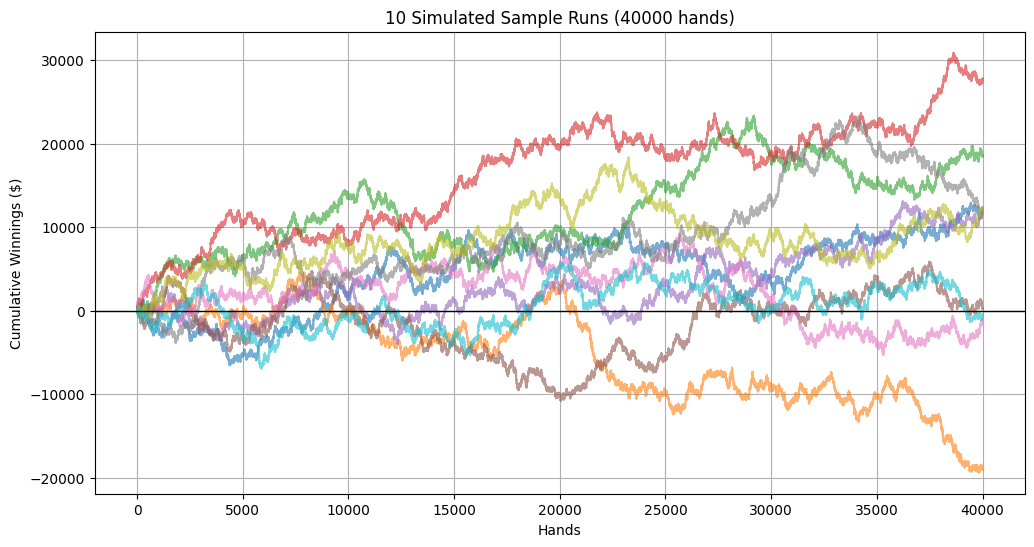

In [118]:

def simulate_run(stakes, wrs, sds, hands):
    total_sample = np.array([])
    
    # Simulate the hands at each stake seperately
    for i, stake in enumerate(stake_bb):
        per_hand = np.random.normal(wrs[i], sds[i], size=hands[i])
        per_hand = stake*per_hand                                           #Scale by bb value of stake to get the win/loss per hand
        total_sample = np.concatenate((total_sample, per_hand))             #Append the hand sample at the given stake
        
    np.random.shuffle(total_sample)                                         #Shuffle the sample so hands appear in random order
    run = np.cumsum(total_sample)                                           
    return run


def plot_multiple_runs(stakes, wrs, sds, hands, runs):
    plt.figure(figsize=(12, 6))

    for i in range(runs):
        run = simulate_run(stakes=stakes, wrs=wrs, sds=sds, hands=hands)
        plt.plot(run, alpha=0.6)

    plt.title(f"{runs} Simulated Sample Runs ({sum(n_hands)} hands)")
    plt.xlabel("Hands")
    plt.ylabel("Cumulative Winnings ($)")
    plt.grid(True)
    plt.axhline(0, color="black", linewidth=1)
    plt.show()

plot_multiple_runs(stakes=stake_bb, wrs=win_rates, sds=sd, hands=n_hands, runs=10)

#TO DO: add risk of ruin stuff

Simulating a bad beat jackpot (BBJ)

This next model allows the possibility of simulating a BBJ and computing it's effect on the variance and distribution of winnings. The default inputs for the BBJ payouts approximate the values found at GG poker and is assumed to be 0 EV. The effects of a BBJ on the variance is massive; it doubles the standard deviation of the winnings. However, the BBJ distribution is skewed right and the loss is capped by the BBJ rake (which is about 2bb/100hands for GG poker), so the standard deviation on winnings or something like a Sharpe ratio does not capture the whole picture. 

The compute the BBJ hit frequency, we assume that bbj_pool is the long term average of what the BBJ prize pool sits at. We then equate the bbj rake paid by each table per hand with the total table payout when the bbj hits. This is a bit of a backwards approach, but should be fairly accurate.
Inputs are assumed to be in big blinds.

 The BBJ hit probability is 0.0000123, which equates to once per 81000.0 hands


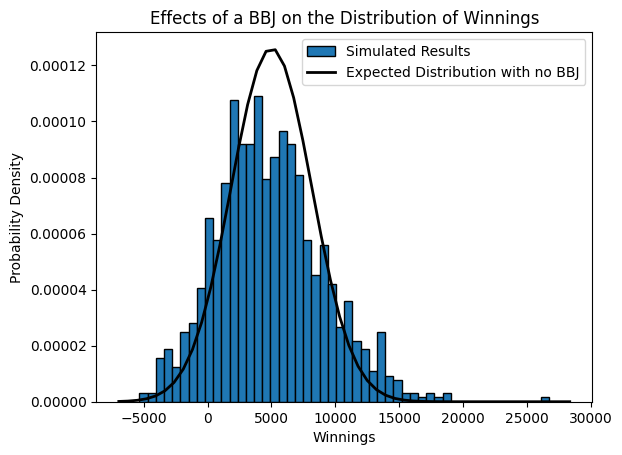

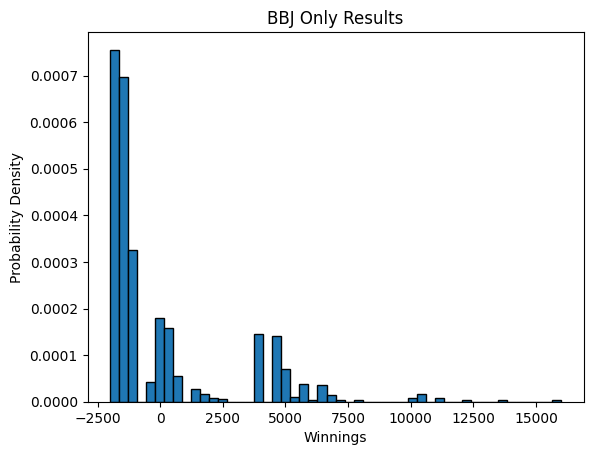

The standard deviation of the hands only is 3162.28, and the corresponding Sharpe ratio is 1.58
The standard deviation of the BBJ results is 2874.67
The standard deviation of the total results is 4273.61, and the corresponding Sharpe ratio is 1.17
The results at the [10, 25, 50, 75, 90] percentiles for the hands only are: [ 954.8 2698.4 4958.  7272.5 8934. ]
The results at the [10, 25, 50, 75, 90] percentiles for the BBJ only are: [-2000. -2000. -1520.   280.  4480.]
The results at the [10, 25, 50, 75, 90] percentiles for both the hands and BBJ: [  -82.8  1972.2  4544.6  7352.3 10376.2]


In [119]:
winrate_100 = 5
sd_100 = 100

winrate = .01*winrate_100      
sd = .1*sd_100

n_hands = 100000
n_sims = 1000

bbj_pool = 60000                                                       #BBJ pool in bb. Corresponds to the jackpot pool per stake on GG Poker
payout_percent_of_pool = np.array([.008, .008, .008, .008, .03, .1])   #Taken from the GG values: 0.8% for table share, 3% winning hand, 10% losing hand
bbj_rake_per_hand = 0.02
bbj_hit_freq = bbj_pool*sum(payout_percent_of_pool)/(6*bbj_rake_per_hand)
bbj_hit_prob = 1/bbj_hit_freq

print(f' The BBJ hit probability is {bbj_hit_prob:.7f}, which equates to once per {bbj_hit_freq:.1f} hands')


#When we hit the BBJ 4/6 times we get the table share, 1/6 the winning hand, 1/6 the losing hand
bbj_payout_probs = (1/bbj_hit_freq)*np.array([bbj_hit_freq - 1, 4/6, 1/6, 1/6])
bbj_payouts = np.array([-0.02, .008 * bbj_pool, .03*bbj_pool, .1*bbj_pool])

def simulation(n_sims, n_hands, winrate, sd):
    mu = winrate
    sigma = sd
    
    total_results = []
    hands_only = []
    bbj_only = []
    
    for i in range(n_sims):
        hands_sim = sum(np.random.normal(mu, sigma, size=n_hands))                           #Single simulation consisting of n_hands
        bbj_sim = sum(np.random.choice(bbj_payouts, size=n_hands, p=bbj_payout_probs))
        hands_only.append(hands_sim)
        bbj_only.append(bbj_sim)
        total_results.append(hands_sim + bbj_sim)
    
    return (total_results, hands_only, bbj_only)


total_results, hands_only, bbj_only = simulation(n_sims, n_hands, winrate, sd)


#plotting a histogram of the total results after n_hands
plt.hist(total_results, bins=50, edgecolor='black', density=True, label='Simulated Results')

plt.xlabel('Winnings')
plt.ylabel('Probability Density')
plt.title('Effects of a BBJ on the Distribution of Winnings')

#Setting the mean and std of the limit normal distribution. From the Central Limit Theorem, the sd scales by the squareroot of n_hands.
mu, sigma = winrate*n_hands, sd*n_hands**.5

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax)

#Limit normal distribution
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, 'k', linewidth=2, label='Expected Distribution with no BBJ')
plt.legend()
plt.show()


#BBJ only results
plt.hist(bbj_only, bins=50, edgecolor='black', density=True)

plt.xlabel('Winnings')
plt.ylabel('Probability Density')
plt.title('BBJ Only Results')

plt.show()


bbj_only_sd = weighted_avg_and_sd(bbj_payouts, bbj_payout_probs)[1]*n_hands**.5        
hands_only_sd = sigma
total_sd = (bbj_only_sd**2 + hands_only_sd**2)**.5                                      #the bbj results and hand results are uncorrelated

print(f"The standard deviation of the hands only is {hands_only_sd:.2f}, and the corresponding Sharpe ratio is {mu/hands_only_sd:.2f}")
print(f"The standard deviation of the BBJ results is {bbj_only_sd:.2f}")
print(f"The standard deviation of the total results is {total_sd:.2f}, and the corresponding Sharpe ratio is {mu/total_sd:.2f}")

percentiles = [10,25,50,75,90]

#Results from the simulated hand samples
print(f"The results at the {percentiles} percentiles for the hands only are: {np.round(np.percentile(hands_only, percentiles), 1)}")
print(f"The results at the {percentiles} percentiles for the BBJ only are: {np.round(np.percentile(bbj_only, percentiles), 1)}")
print(f"The results at the {percentiles} percentiles for both the hands and BBJ: {np.round(np.percentile(total_results, percentiles), 1)}")


Model allowing moving up and down in stakes when certain threshold conditions are met. Can possibly be used for stuff like helping to find a fair staking arrangement between a player and a backer for a player moving up in stakes.

In [120]:
#TO FINISH

Justification for the Normal distribution assumption of hand results

The empirical wins and losses per hand are approximated from a sample of 600k I've played in a PokerTracker 4 database with the average win/loss normalized to 0. The empirical_sd of 10 big blinds per hand corresponds to 100 per 100 hands, which is approximately the average in 6-handed nlh games. After a few hundred hands, the limit Normal distribution with mu = empirical_mean and sigma = empirical_sd*sqrt(n_hands) closely approximates the simulated distribution of winnings.

True winrate and standard deviation per hand: 0.00, 10.05


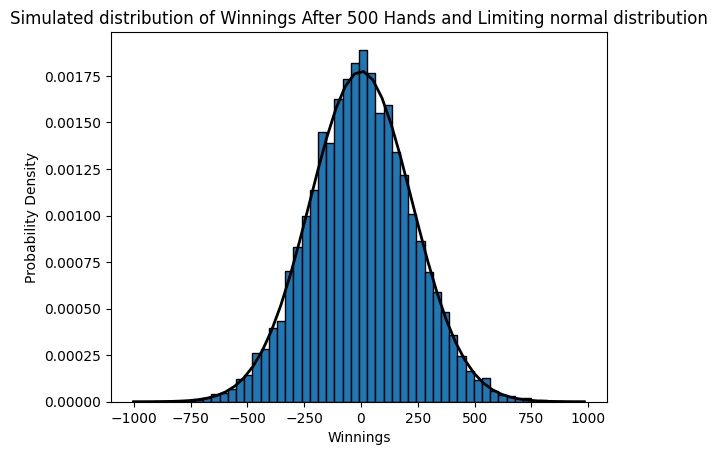

In [121]:
n_hands = 500                                                                          #number of hands to be simulated for each simulation batch
n_sims = 10000                                                                         #number of simulation batches, each with n_hands
win_loss = np.array([-100, -30, -10, -3, -1, 0, 1, 3, 10, 30, 100])                    #empirical win and loss sizes bb
win_loss_probs = 0.01*np.array([.35, 1.3, 3, 7, 16.5, 43.7, 16.5, 7, 3, 1.3, .35])     #empirical win/loss frequencies

#plt.hist(win_loss_probs, bins = win_loss, width=bin_width, edgecolor='black')
#plt.show()

def simulation(n_sims, n_hands):
    sims = []
    for i in range(n_sims):
        sim = np.random.choice(win_loss, size=n_hands, p=win_loss_probs)
        sims.append(sum(sim))
    return sims

#running n_sims iterations of the simulation, each simulating n_hands from the empirical win/loss distribution
sims = simulation(n_sims, n_hands)

#plotting a histogram of the simulated wins/losses in bb after n_hands
plt.hist(sims, bins=50, edgecolor='black', density = True)

# Plotting the results
plt.xlabel('Winnings')
plt.ylabel('Probability Density')
plt.title(f'Simulated distribution of Winnings After {n_hands} Hands and Limiting normal distribution')


empirical_mean, empirical_sd = weighted_avg_and_sd(win_loss, win_loss_probs)    #True winrate and sd per hand, based on data provided
print(f"True winrate and standard deviation per hand: {empirical_mean:.2f}, {empirical_sd:.2f}")

mu, sigma = empirical_mean*n_hands, empirical_sd*n_hands**.5                        #Expected limiting distribution for samples of n_hands.

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax)

#Limit normal distribution
y = norm.pdf(x, mu, sigma)

plt.plot(x, y, 'k', linewidth=2)

plt.show()